In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
dropout_value = 0.005
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) 
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 12, 3) 
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 16, 3)
        self.bn3 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(16, 8, 1)
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(8, 12, 3)
        self.bn5 = nn.BatchNorm2d(12)
        self.conv6 = nn.Conv2d(12,16,3)
        self.bn6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16,16,3)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.Conv2d(16,16,3)
        self.bn8 = nn.BatchNorm2d(16)
        self.conv9 = nn.Conv2d(16,10,1)
        self.avg = nn.AvgPool2d(3)
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.dropout(self.bn1(F.relu(self.conv1(x))))#28 - 26 - 3
        x = self.dropout(self.bn2(F.relu(self.conv2(x))))#26 - 24 - 5
        x = self.dropout(self.bn3(F.relu(self.conv3(x))))#24 - 22 - 7
        x = self.pool(x)#22 - 11 - 8
        x = self.dropout(self.bn4(F.relu(self.conv4(x))))#11 - 11 - 8
        x = self.dropout(self.bn5(F.relu(self.conv5(x))))#11 - 9 - 12
        x = self.dropout(self.bn6(F.relu(self.conv6(x))))#9 - 7 - 16
        x = self.dropout(self.bn7(F.relu(self.conv7(x))))#7 - 5 - 20
        x = self.dropout(self.bn8(F.relu(self.conv8(x))))#5 - 3 - 24
        x = F.relu(self.conv9(x))#3 - 3 - 24
        x = self.avg(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]             876
       BatchNorm2d-5           [-1, 12, 24, 24]              24
           Dropout-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,744
       BatchNorm2d-8           [-1, 16, 22, 22]              32
           Dropout-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11            [-1, 8, 11, 11]             136
      BatchNorm2d-12            [-1, 8, 11, 11]              16
          Dropout-13            [-1, 8, 11, 11]               0
           Conv2d-14             [-1, 1

In [ ]:
torch.manual_seed(1)
batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                                transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                transforms.Resize((28, 28)),
                                transforms.RandomRotation((-15., 15.), fill=0),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3774 Batch_id=117 Accuracy=71.79: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Test set: Average loss: 0.1960, Accuracy: 9686/10000 (96.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1188 Batch_id=117 Accuracy=96.16: 100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Test set: Average loss: 0.0841, Accuracy: 9796/10000 (97.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1049 Batch_id=117 Accuracy=97.49: 100%|██████████| 118/118 [00:27<00:00,  4.30it/s]


Test set: Average loss: 0.0562, Accuracy: 9861/10000 (98.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1825 Batch_id=117 Accuracy=97.86: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Test set: Average loss: 0.0491, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0845 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Test set: Average loss: 0.0398, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0342 Batch_id=117 Accuracy=98.24: 100%|██████████| 118/118 [00:26<00:00,  4.37it/s]


Test set: Average loss: 0.0338, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0976 Batch_id=117 Accuracy=98.45: 100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Test set: Average loss: 0.0369, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0280 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Test set: Average loss: 0.0345, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0610 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:27<00:00,  4.31it/s]


Test set: Average loss: 0.0305, Accuracy: 9911/10000 (99.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0640 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Test set: Average loss: 0.0266, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1252 Batch_id=117 Accuracy=98.71: 100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0275 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:27<00:00,  4.32it/s]


Test set: Average loss: 0.0279, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0500 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Test set: Average loss: 0.0259, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0851 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0716 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0376 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Test set: Average loss: 0.0215, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0282 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0378 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0467 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0260 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-03.


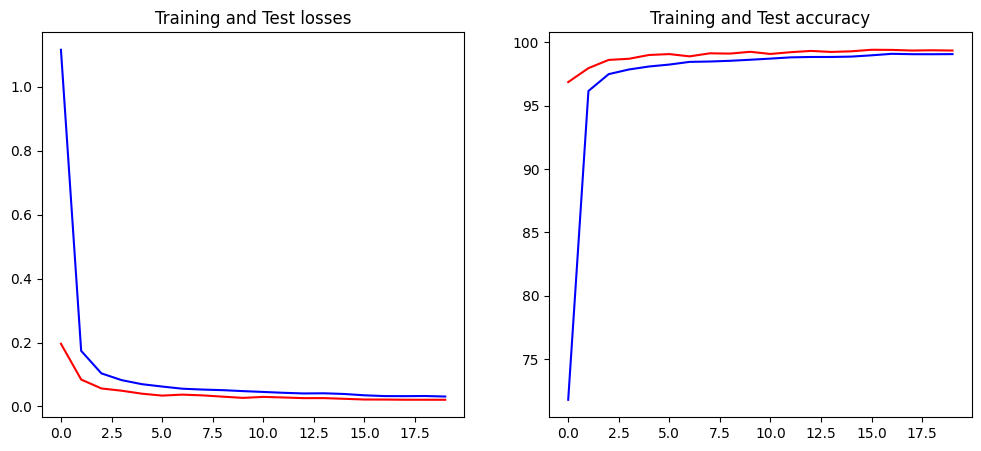

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(train_losses, c='blue')
ax1.plot(test_losses, c='red')
ax1.title.set_text('Training and Test losses')

ax2.plot(train_acc, c='blue')
ax2.plot(test_acc, c='red')
ax2.title.set_text('Training and Test accuracy')

In [ ]:
max(test_acc)

99.41